![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Linear Regression and Optimization

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/iwh-halle/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/iwh-halle/FinancialDataAnalytics/discussions

In this assignment you will work with data that is stored in a file named **02_python_data.csv**, which contains daily stock prices for various companies listed on Deutsche Börse (Xetra). The columns are labeled with Reuters identifier code (RIC). The first RIC '.GDAXI' is the german DAX index, the remaining RICs represent its constituents.

In this exercise we will compare the **DAX index** (.GDAXI) to a portfolio build from the **constituents** (the remaining columns).

### Task:

Find the vector of weights $\mathbf{w}$ for the [Minimum Variance Portfolio (MVP)](https://en.wikipedia.org/wiki/Modern_portfolio_theory) using only the constituents (not .GDAXI). Print risk ($\sigma$) and return ($\mu$) of both, DAX and MVP. Show in a single graph the cumulative log-returns of both portfolios. Please note that the sum of $\mathbf{w}$ must be $100$%. ALso, you are not allowed to use short positions, i.e. $w \ge 0\ \forall\ w \in \mathbf{w}$.

Hint: The portfolio variance - which we want to minimize - is given by
$$
\sigma^2_\text{Portfolio} = \mathbf{w}^\intercal \mathbf{\Sigma} \mathbf{w},
$$
where $\mathbf{\Sigma}$ is the correlation matrix of the portfolio constituents.

Optimale Gewichtungen: 
[0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103 0.02564103
 0.02564103 0.02564103 0.02564103]
Minimale Portfolio-Varianz: 0.3810


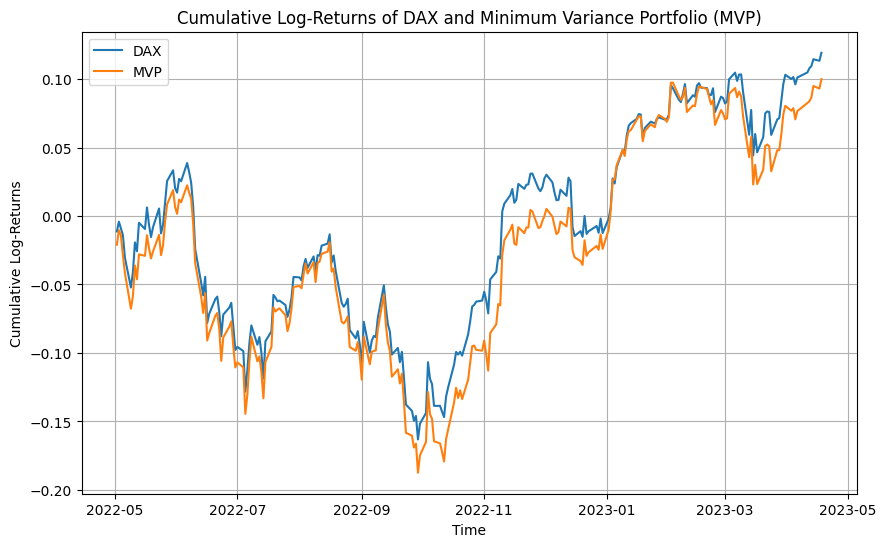

DAX Portfolio:
Return: 0.0006
Risk: 0.0121

Minimum Variance Portfolio (MVP):
Return: 0.0005
Risk: 0.6172


In [44]:

import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Read data from CSV file and extract constituents
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)
constituents=prices.drop(columns='.GDAXI')

# Correlation Matrix
correl_mat=constituents.corr()

#Define function to optimize
def portfolio_variance(weights):
    return np.dot(weights.T , np.dot(correl_mat , weights))

# Constraints for scipy.optimize
cons = ( 
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Equality constraint: sum of weights equals 1
    {'type': 'ineq', 'fun': lambda w: -w}  # Inequality constraint: each weight >= 0, did not work like this?
)

initial_weights = np.array([1.0 / len(correl_mat)] * len(correl_mat))

# Define bounds for each weight (0 <= weight <= 1)
bounds = [(0, 1)] * len(initial_weights)

# Minimize portfolio variance subject to constraints
result = minimize(portfolio_variance, initial_weights, constraints=cons, bounds=bounds)


initial_weights = np.array([1.0 / len(correl_mat)] * len(correl_mat))

# Minimize portfolio variance subject to constraints
result = minimize(portfolio_variance, initial_weights, constraints=cons)


# print results 
optimal_weights = result.x
min_variance = result.fun
# results are wrong, because the optimization is not working correctly

print("Optimale Gewichtungen: ",optimal_weights, sep='\n')
print(f"Minimale Portfolio-Varianz: {min_variance:,.4f}")


# Calculate portfolio return of DAX (assuming equal weights)
dax_return = np.mean(prices['.GDAXI'].pct_change().dropna()) 

# Calculate portfolio risk of DAX (assuming equal weights)
dax_risk = np.std(prices['.GDAXI'].pct_change().dropna()) 

# Calculate portfolio return of MVP
mvp_return = np.sum(optimal_weights * np.mean(constituents.pct_change().dropna()) )

# Calculate portfolio risk of MVP
mvp_risk = np.sqrt(min_variance) 

# Plot cumulative log-returns of both portfolios
dax_cumulative_returns = np.cumsum(np.log(1 + prices['.GDAXI'].pct_change().dropna()))
mvp_cumulative_returns = np.cumsum(np.log(1 + np.sum(optimal_weights * constituents.pct_change().dropna(), axis=1)))

plt.figure(figsize=(10, 6))
plt.plot(dax_cumulative_returns, label='DAX')
plt.plot(mvp_cumulative_returns, label='MVP')
plt.title('Cumulative Log-Returns of DAX and Minimum Variance Portfolio (MVP)')
plt.xlabel('Time')
plt.ylabel('Cumulative Log-Returns')
plt.legend()
plt.grid(True)
plt.show()

# Print risk and return of DAX and MVP
print("DAX Portfolio:")
print(f"Return: {dax_return:.4f}")
print(f"Risk: {dax_risk:.4f}")

print("\nMinimum Variance Portfolio (MVP):")
print(f"Return: {mvp_return:.4f}")
print(f"Risk: {mvp_risk:.4f}")




### Task:

Use a linear regression model to find the actual weights of the index constituents that are required to replicate (i.e. explain) the returns of the DAX index. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

DAX Mean Return: 0.0006
DAX Risk: 0.0121
Replicating Portfolio Mean Return: 0.0006
Replicationg Portfolio Risk: 0.0120


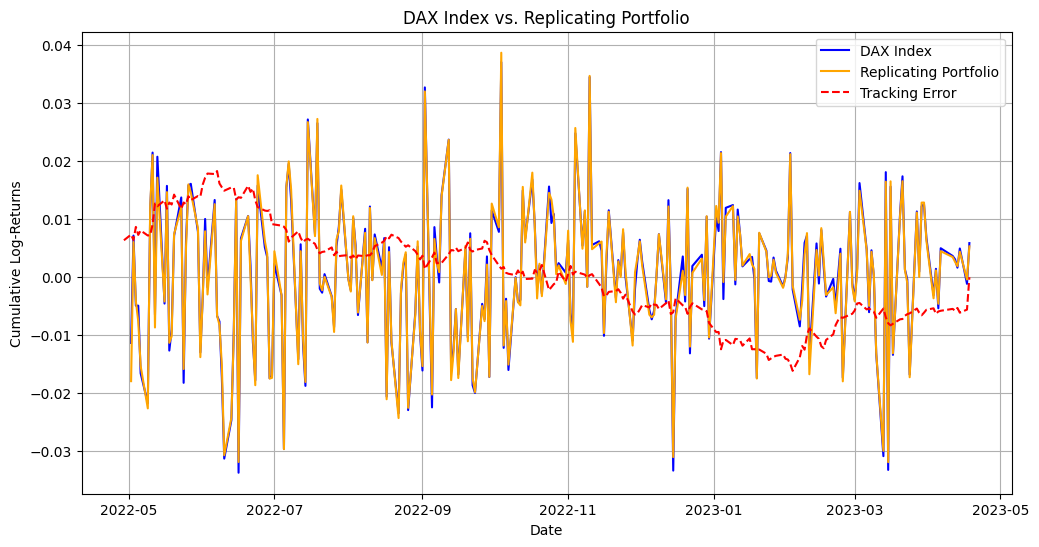

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Read data from CSV file and extract constituents
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)
constituents = prices.drop(columns='.GDAXI')

# Calculate returns
dax_returns = prices['.GDAXI'].pct_change().dropna()
constituents_returns = constituents.pct_change().dropna()

#Calculate log returns
logreturns_dax = np.log(prices['.GDAXI']) - np.log(prices['.GDAXI'].shift(1))
logreturns_const = np.log(prices.drop(columns='.GDAXI')) - np.log(prices.drop(columns='.GDAXI')).shift(1)

# Fit linear regression model
model = LinearRegression()
model.fit(constituents_returns, dax_returns)

# Get the coefficients (weights) of the regression model
constituent_weights = model.coef_

# Calculate returns of the replicating portfolio
replicating_portfolio_returns = np.dot(constituents_returns, constituent_weights)
replicating_portfolio_risk = np.std(replicating_portfolio_returns, axis=0)
replicating_portfolio_mean_return = np.mean(replicating_portfolio_returns, axis=0)

# Calculate the log returns for the replicating portfolio
logreturns_repl_port = np.dot(logreturns_const, constituent_weights)

#Calculate the cummulative log returns
cumm_logreturns_repl_port=logreturns_repl_port.cumsum()
cumm_logreturns_dax=logreturns_dax.cumsum()

#print everything
print(f"DAX Mean Return: {np.mean(dax_returns, axis=0):,.4f}")
print(f"DAX Risk: {np.std(dax_returns, axis=0):,.4f}")
print(f"Replicating Portfolio Mean Return: {replicating_portfolio_mean_return:,.4f}")
print(f"Replicationg Portfolio Risk: {np.std(replicating_portfolio_returns, axis=0):,.4f}")

# Calculate tracking error
tracking_error = dax_returns.cumsum() - replicating_portfolio_returns.cumsum()

# Needs to be extended to match dimensions
tracking_error_extended = tracking_error.values.tolist() + [0]

# Verify lengths of arrays
#print("Length of DAX index:", len(prices.index))
#print("Length of log returns for DAX:", len(logreturns_dax))
#print("Length of log returns for replicating portfolio:", len(logreturns_repl_port))
#print("Length of tracking error:", len(tracking_error_extended))

# Plotting
plt.figure(figsize=(12, 6))

# Plot cumulative log-returns of DAX index and replicating portfolio
plt.plot(prices.index, logreturns_dax, label='DAX Index', color='blue')
plt.plot(prices.index, logreturns_repl_port, label='Replicating Portfolio', color='orange')

# Plot tracking error
plt.plot(prices.index, tracking_error_extended, label='Tracking Error', color='red', linestyle='--')

plt.title('DAX Index vs. Replicating Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns')
plt.legend()
plt.grid(True)
plt.savefig('05_optimization_Lin_Regre.png')
plt.show()


### Task:

We want to create a ["smart-beta"](https://en.wikipedia.org/wiki/Smart_beta) strategy that replicates the DAX index returns using only a subset of its constituents. This is, maximize the fit of the model using only $3$ constituents. This process is similar to [feature selection](https://en.wikipedia.org/wiki/Feature_selection) in machine learning. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

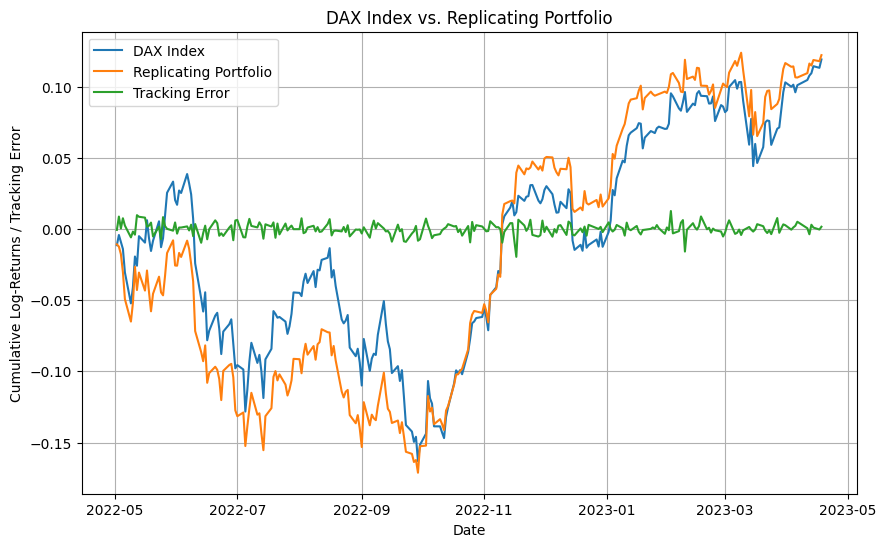

DAX Portfolio:
Return: 0.0006
Risk: 0.0121

Replicating Portfolio:
Return: 0.1398
Risk: 0.1792


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Read data from CSV file and extract constituents
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)
constituents = prices.drop(columns='.GDAXI')

# Calculate returns
dax_returns = prices['.GDAXI'].pct_change().dropna()
constituents_returns = constituents.pct_change().dropna()

# Fit linear regression model using all constituents
model_all = LinearRegression()
model_all.fit(constituents_returns, dax_returns)

# Get coefficients (weights) of the regression model
constituent_weights_all = model_all.coef_

# Perform feature selection to select three constituents with highest coefficients
selected_constituents = np.argsort(np.abs(constituent_weights_all))[-3:]
selected_constituents_names = constituents.columns[selected_constituents]

# Refit the model using only the selected subset of constituents
model_selected = LinearRegression()
model_selected.fit(constituents_returns[selected_constituents_names], dax_returns)

# Get coefficients (weights) of the regression model for selected constituents
constituent_weights_selected = model_selected.coef_

# Calculate replicating portfolio returns
replicating_returns = np.dot(constituents_returns[selected_constituents_names], constituent_weights_selected)
replicating_risk = np.std(replicating_returns) * np.sqrt(252)
replicating_return = np.mean(replicating_returns) * 252

# Calculate tracking error
tracking_error = dax_returns - replicating_returns

# Calculate cumulative log-returns of DAX and replicating portfolio
dax_cumulative_returns = np.cumsum(np.log(1 + dax_returns))
replicating_cumulative_returns = np.cumsum(np.log(1 + replicating_returns))

# Plot cumulative log-returns and tracking error
plt.figure(figsize=(10, 6))
plt.plot(prices.index[1:], dax_cumulative_returns, label='DAX Index')
plt.plot(prices.index[1:], replicating_cumulative_returns, label='Replicating Portfolio')
plt.plot(prices.index[1:], tracking_error, label='Tracking Error')
plt.title('DAX Index vs. Replicating Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns / Tracking Error')
plt.legend()
plt.grid(True)
plt.show()

# Print risk and return of DAX and replicating portfolio
print("DAX Portfolio:")
print(f"Return: {np.mean(dax_returns):.4f}")
print(f"Risk: {np.std(dax_returns):.4f}")

print("\nReplicating Portfolio:")
print(f"Return: {replicating_return:.4f}")
print(f"Risk: {replicating_risk:.4f}")
